In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def generate_result(auc_b_c, auc_b_light, auc_c_light, label=""):
    result = {}
    result['b vs c'] = [auc_b_c]
    result['b vs light'] = [auc_b_light]
    result['c vs light'] = [auc_c_light]
    result['name'] = [label]
    return pandas.DataFrame(result)

In [13]:
import root_numpy
import pandas
from rep.data import LabeledDataStorage
#from hep_ml.decisiontrain import DecisionTrainClassifier, DecisionTrainRegressor
from hep_ml.losses import LogLossFunction, MSELossFunction
from rep.metaml import FoldingClassifier, FoldingRegressor
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

## Read data

In [4]:
treename = 'tag'

data_b = pandas.DataFrame(root_numpy.root2array('datasets/type=5.root', treename=treename)).dropna()
data_b = data_b[::40]
data_c = pandas.DataFrame(root_numpy.root2array('datasets/type=4.root', treename=treename)).dropna()
data_light = pandas.DataFrame(root_numpy.root2array('datasets/type=0.root', treename=treename)).dropna()

In [5]:
data = {'b': data_b, 'c': data_c, 'light': data_light}

### Add features

In [6]:
for d in data.values():
    d['log_SVFDChi2'] = numpy.log(d['SVFDChi2'].values)
    d['log_SVSumIPChi2'] = numpy.log(d['SVSumIPChi2'].values)

In [7]:
len(data_b), len(data_c), len(data_light)

(46090, 19941, 42423)

In [8]:
jet_features = [column for column in data_b.columns if "Jet" in column]
sv_features = [column for column in data_b.columns if "SV" in column]

In [9]:
print "Jet features", ", ".join(jet_features)
print "SV features", ", ".join(sv_features)

Jet features JetParton, JetFlavor, JetPx, JetPy, JetPz, JetE, JetQ, JetSigma1, JetSigma2, JetMult, JetPTHard, JetPTD, JetNDis
SV features SVM, SVMC, SVR, SVPT, SVDR, SVN, SVQ, SVFDChi2, SVSumIPChi2, log_SVFDChi2, log_SVSumIPChi2


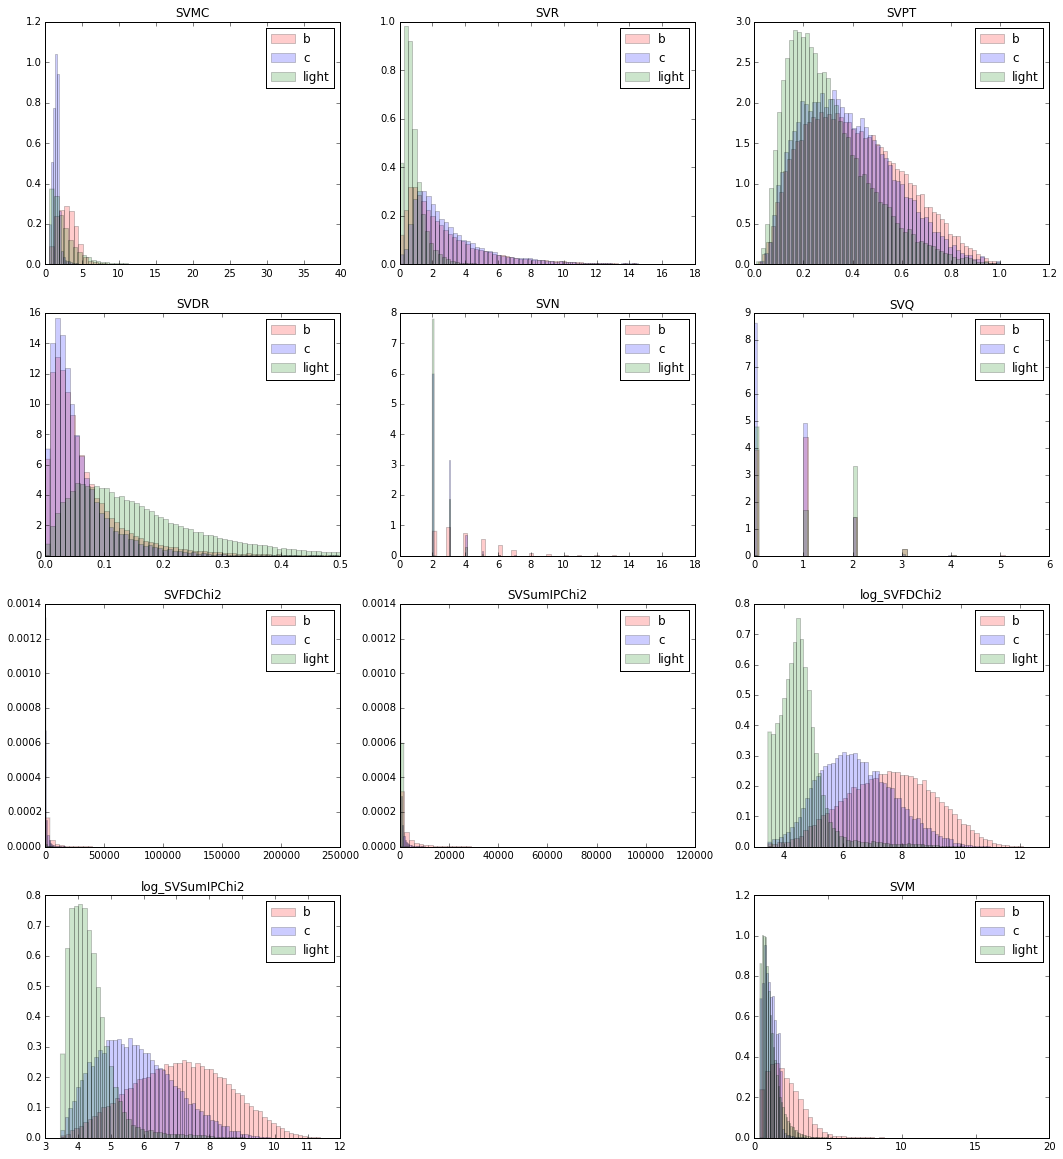

In [10]:
figsize(18, 20)
for i, feature in enumerate(sv_features):
    subplot(len(sv_features) / 3 + 1, 3, i)
    hist(data_b[feature].values, label='b', alpha=0.2, bins=60, normed=True)
    hist(data_c[feature].values, label='c', alpha=0.2, bins=60, normed=True)
    hist(data_light[feature].values, label='light', alpha=0.2, bins=60, normed=True)
    title(feature); legend(loc='best'); 

In [13]:
figsize(8, 6)

# Old scheme

## Prepare datasets:
* b vs c
* b, c vs light

In [14]:
data_b_c_lds = LabeledDataStorage(pandas.concat([data_b, data_c]), [1] * len(data_b) + [0] * len(data_c))
data_bc_light_lds = LabeledDataStorage(pandas.concat([data_b, data_c, data_light]), 
                                       [1] * len(data_b) + [1] * len(data_c) + [0] * len(data_light))

### b vs c jets

In [18]:
tt_base = RandomForestClassifier(n_estimators=50, max_depth=6, 
                                  max_features=6)
tt_folding_b_c = FoldingClassifier(tt_base, n_folds=2, random_state=11, 
                                   features=sv_features)
%time tt_folding_b_c.fit_lds(data_b_c_lds)
pass

CPU times: user 8.35 s, sys: 36.3 ms, total: 8.39 s
Wall time: 8.42 s


In [19]:
report = ClassificationReport({'b vs c': tt_folding_b_c}, data_b_c_lds)

KFold prediction using folds column


KFold prediction using folds column
Estimator b vs c doesn't support stage predictions


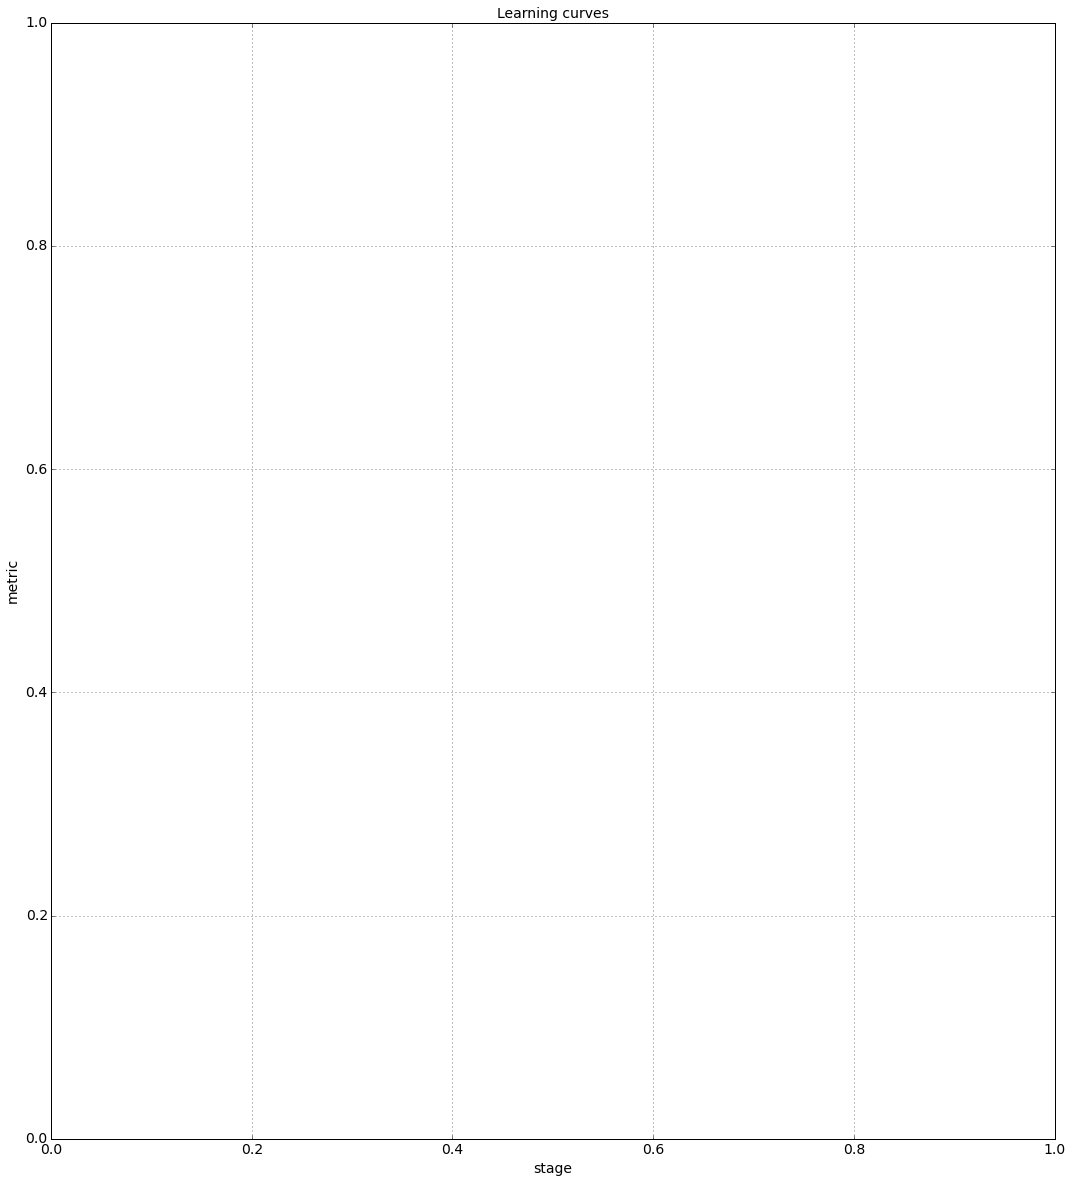

In [20]:
report.learning_curve(RocAuc())

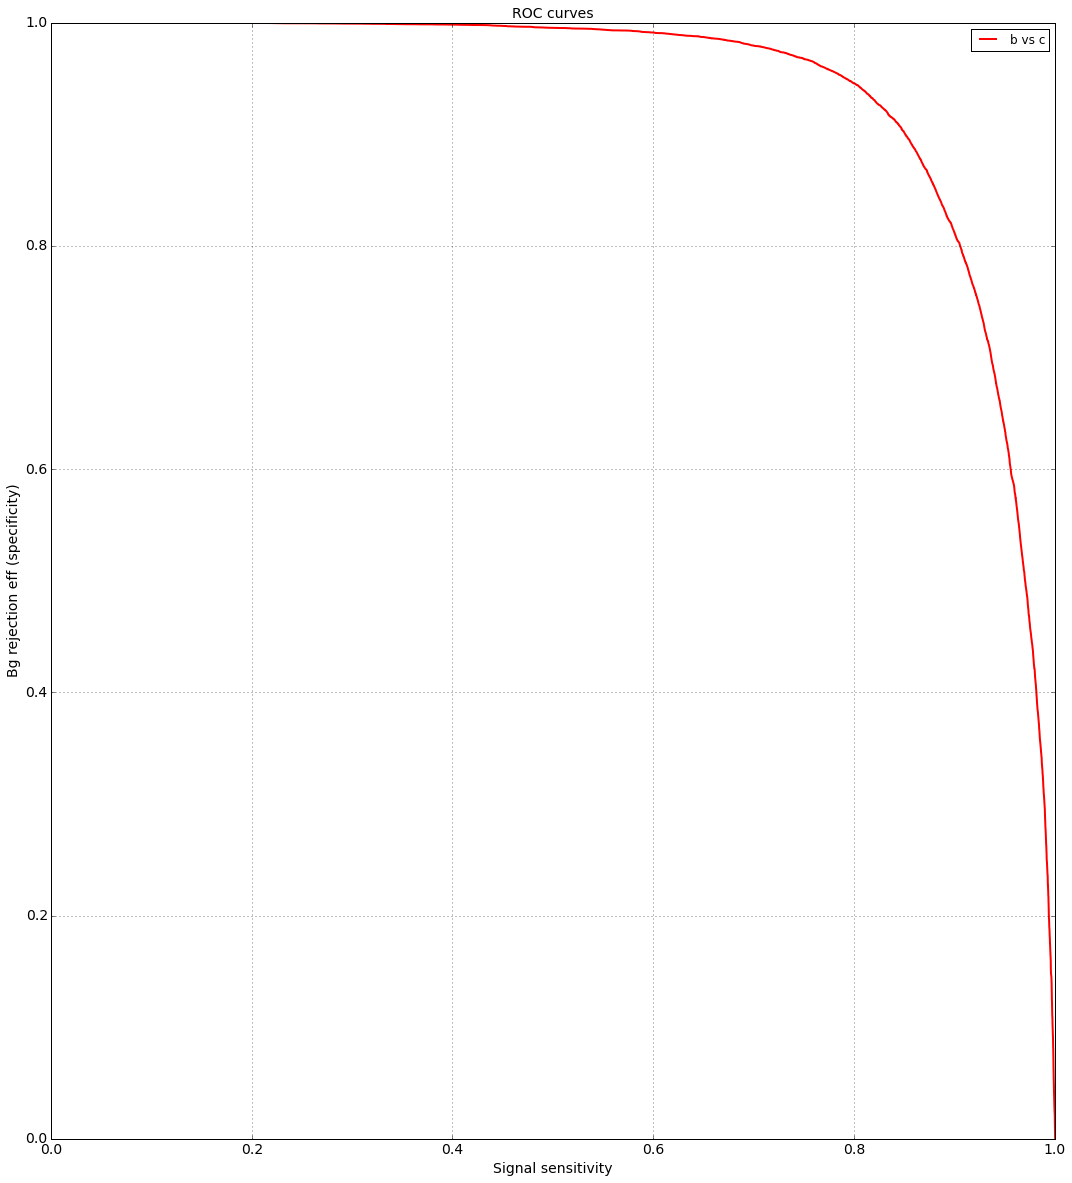

In [21]:
report.roc()

In [22]:
auc_b_c = report.compute_metric(RocAuc())['b vs c']

### b, c vs light jets

In [23]:
tt_base = RandomForestClassifier(n_estimators=50, max_depth=6, 
                                  max_features=6)
tt_folding_bc_light = FoldingClassifier(tt_base, n_folds=2, random_state=11, features=sv_features)
%time tt_folding_bc_light.fit_lds(data_bc_light_lds)
pass

CPU times: user 16.4 s, sys: 192 ms, total: 16.5 s
Wall time: 17.6 s


In [24]:
report = ClassificationReport({'tt b, c vs light': tt_folding_bc_light}, data_bc_light_lds)

KFold prediction using folds column


KFold prediction using folds column


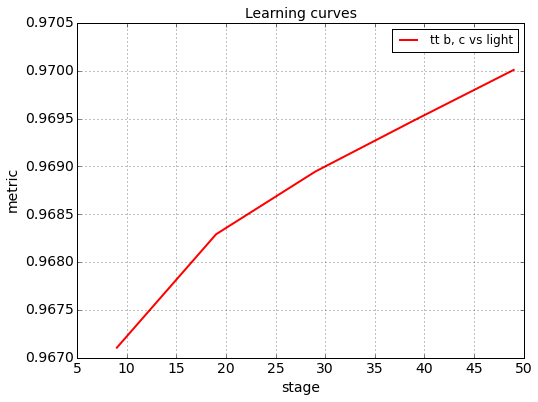

In [22]:
report.learning_curve(RocAuc())

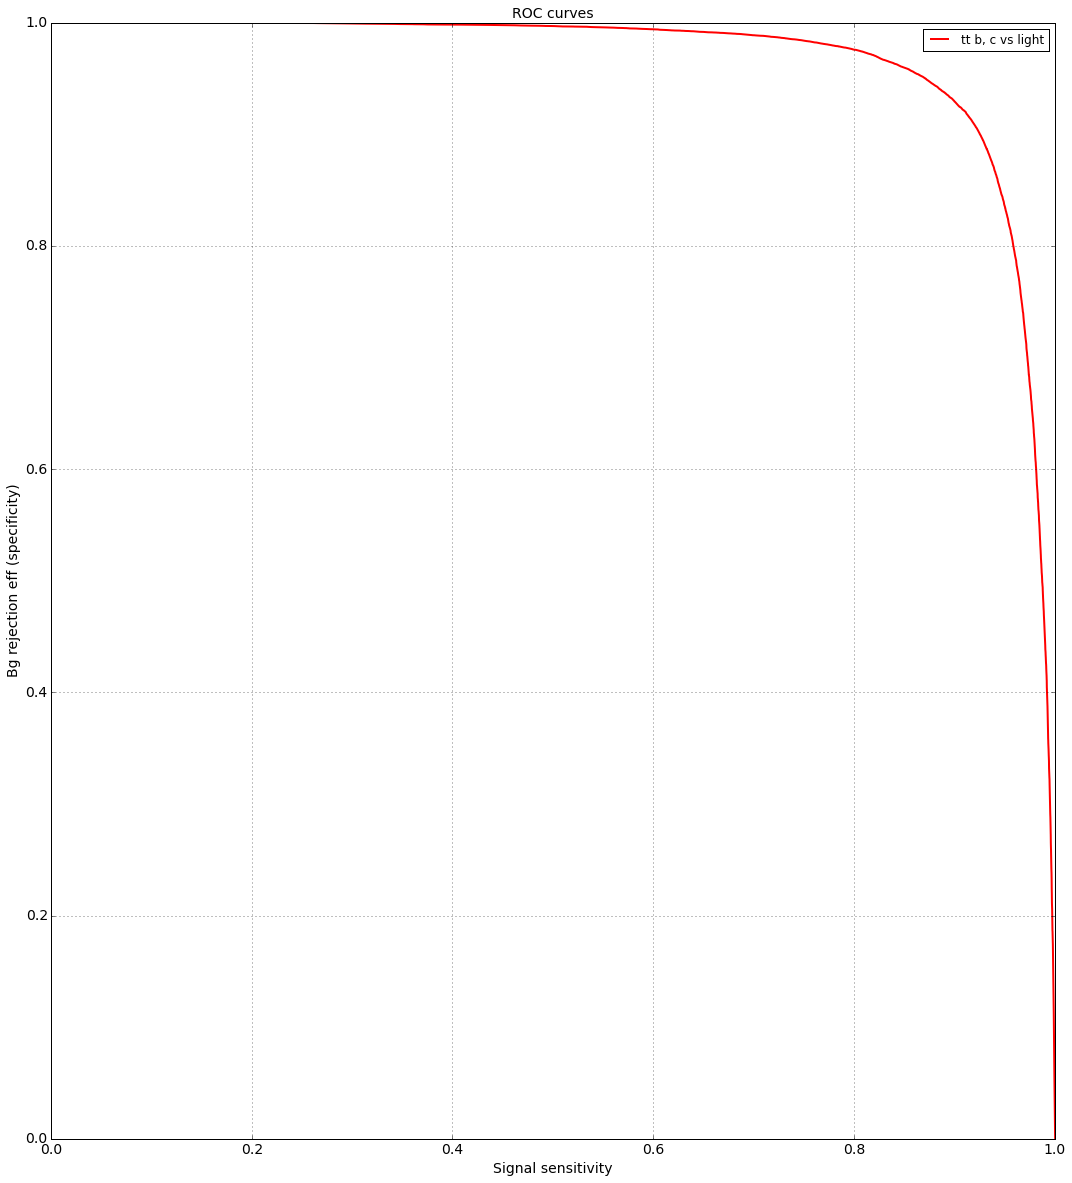

In [25]:
report.roc()

In [26]:
report.compute_metric(RocAuc())

OrderedDict([('tt b, c vs light', 0.96777479689888257)])

In [27]:
p_b_c = tt_folding_b_c.predict_proba(pandas.concat([data_b, data_c]))[:, 1]
p_b_c_light = tt_folding_b_c.predict_proba(data_light)[:, 1]
p_bc_light = tt_folding_bc_light.predict_proba(pandas.concat([data_b, data_c, data_light]))[:, 1]

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column


In [28]:
bdt1 = numpy.concatenate([p_b_c, p_b_c_light])
bdt2 = p_bc_light

In [29]:
labels = numpy.array([2] * len(data_b) + [1] * len(data_c) + [0] * len(data_light))
baseline_result = generate_result(auc_b_c, 
                                  roc_auc_score(labels > 1, p_bc_light, sample_weight=(labels != 1) * 1),
                                  roc_auc_score(labels > 0, p_bc_light, sample_weight=(labels != 2) * 1),
                                  label='baseline')

In [30]:
baseline_result

,b vs c,b vs light,c vs light,name
0,0.941541,0.975252,0.950493,baseline


### BDTs planes

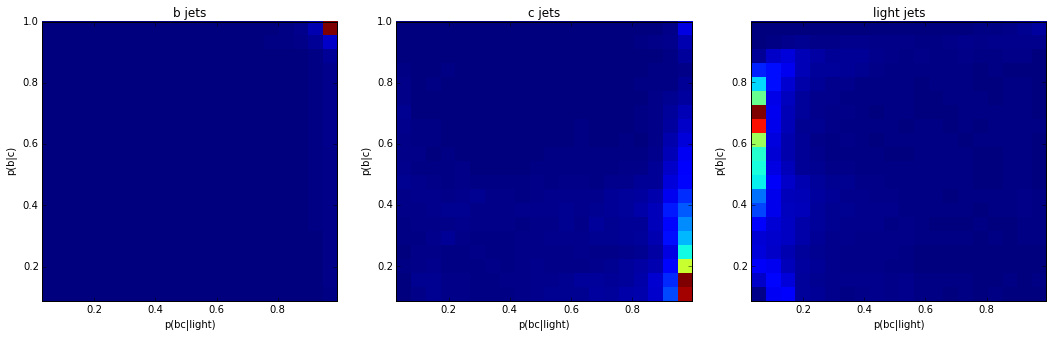

In [31]:
plt.figure(figsize=[18, 5])

plt.subplot(1,3,1)
hist2d(p_bc_light[:len(data_b)], p_b_c[:len(data_b)], normed=True, bins=20), xlabel('p(bc|light)'), 
ylabel('p(b|c)'), title('b jets')

plt.subplot(1,3,2)
hist2d(p_bc_light[len(data_b):len(data_b) + len(data_c)],
        p_b_c[len(data_b):len(data_b) + len(data_c)], bins=20, normed=True), 
xlabel('p(bc|light)'), ylabel('p(b|c)'), title('c jets')

plt.subplot(1,3,3)
hist2d(p_bc_light[len(data_b) + len(data_c):], p_b_c_light, bins=20, normed=True), xlabel('p(bc|light)'), 
ylabel('p(b|c)'), title('light jets')
pass

In [32]:
full_data = pandas.concat([data_b, data_c, data_light])
full_data['bdt1'] = bdt1
full_data['bdt2'] = bdt2
full_data['label'] = [0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light)

# Multiclassification

In [33]:
data_multi_lds = LabeledDataStorage(full_data, 'label')

In [34]:
from rep.estimators import XGBoostClassifier
# xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=8, 
#                              subsample=0.5, max_depth=8)
xgb_base = RandomForestClassifier(n_estimators=50, max_depth=8)
multi_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11, features=sv_features)
%time multi_folding.fit_lds(data_multi_lds)

CPU times: user 9.93 s, sys: 46.3 ms, total: 9.98 s
Wall time: 10 s


FoldingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
         features=['SVM', 'SVMC', 'SVR', 'SVPT', 'SVDR', 'SVN', 'SVQ', 'SVFDChi2', 'SVSumIPChi2', 'log_SVFDChi2', 'log_SVSumIPChi2'],
         n_folds=2, parallel_profile=None, random_state=11)

In [35]:
multi_probs = multi_folding.predict_proba(full_data)

KFold prediction using folds column


### Confusion matrix

In [36]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    names = ['b', 'c', 'light']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [37]:
cm = confusion_matrix([0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light), numpy.argmax(multi_probs, axis=1))

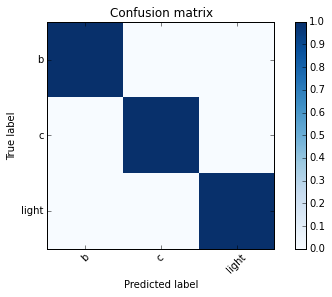

In [38]:
figsize(6, 4)
plot_confusion_matrix(cm / numpy.max(cm, axis=0))

In [39]:
labels = numpy.array([0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light))

In [40]:
'log loss', -numpy.log(multi_probs[numpy.arange(len(multi_probs)), labels]).sum() / len(labels)

('log loss', 0.39249401203095352)

In [41]:
labels = numpy.array([0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light))
multiclass_result = generate_result(1 - roc_auc_score(labels > 0, multi_probs[:, 0] / multi_probs[:, 1], 
                                                      sample_weight=(labels != 2) * 1),
                                    1 - roc_auc_score(labels > 1, multi_probs[:, 0] / multi_probs[:, 2],
                                                      sample_weight=(labels != 1) * 1),
                                    1 - roc_auc_score(labels > 1, multi_probs[:, 1] / multi_probs[:, 2],
                                                      sample_weight=(labels != 0) * 1),
                                    label='multiclass')

In [42]:
result = pandas.concat([baseline_result, multiclass_result])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
baseline,0.941541,0.975252,0.950493
multiclass,0.940683,0.978422,0.962802


In [43]:
multi_probs_b = multi_probs[:len(data_b), :]  
multi_probs_c = multi_probs[len(data_b) : len(data_b) + len(data_c), :]
multi_probs_light = multi_probs[len(data_b) + len(data_c):, :]

# Probabilities in space and its transformations

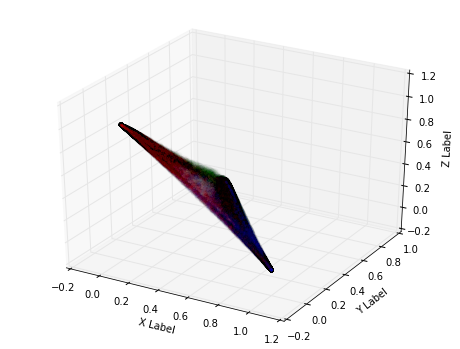

In [70]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(multi_probs[labels==0, 0], multi_probs[labels==0, 1], multi_probs[labels==0, 2], c='b', alpha=0.01)
ax.scatter(multi_probs[labels==1, 0], multi_probs[labels==1, 1], multi_probs[labels==1, 2], c='g', alpha=0.01)
ax.scatter(multi_probs[labels==2, 0], multi_probs[labels==2, 1], multi_probs[labels==2, 2], c='r', alpha=0.01)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [73]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(multi_probs)
new_probs = pca.transform(multi_probs)

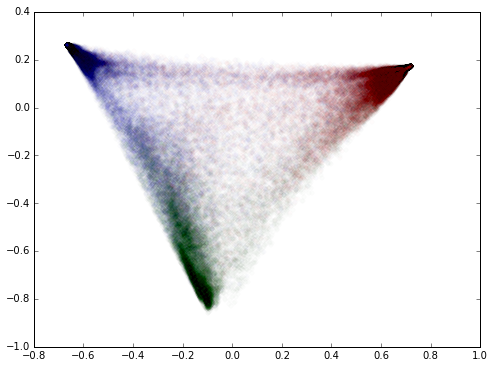

In [88]:
plt.scatter(new_probs[labels==0, 0], new_probs[labels==0, 1], c='b', alpha=0.01)
plt.scatter(new_probs[labels==1, 0], new_probs[labels==1, 1], c='g', alpha=0.01)
plt.scatter(new_probs[labels==2, 0], new_probs[labels==2, 1], c='r', alpha=0.01)
plt.show()

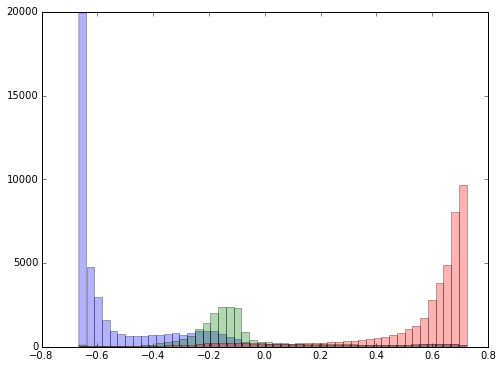

In [82]:
plt.hist(new_probs[labels==0, 0], bins=50, color='b', alpha=0.3)
plt.hist(new_probs[labels==1, 0], bins=50, color='g', alpha=0.3)
plt.hist(new_probs[labels==2, 0], bins=50, color='r', alpha=0.3)
plt.show()

In [83]:
reg_labels = full_data.label.values
reg_values = new_probs[:, 0]
regression_result = generate_result(roc_auc_score(reg_labels > 0, reg_values, sample_weight=(reg_labels != 2)*1),
                                    roc_auc_score(reg_labels > 0, reg_values, sample_weight=(reg_labels != 1)*1),
                                    roc_auc_score(reg_labels > 1, reg_values, sample_weight=(reg_labels != 0)*1), 
                                    label='regression')

In [84]:
result = pandas.concat([pandas.DataFrame(baseline_result), pandas.DataFrame(multiclass_result),
                       regression_result])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
baseline,0.941541,0.975252,0.950493
multiclass,0.940683,0.978422,0.962802
regression,0.877894,0.976522,0.930377


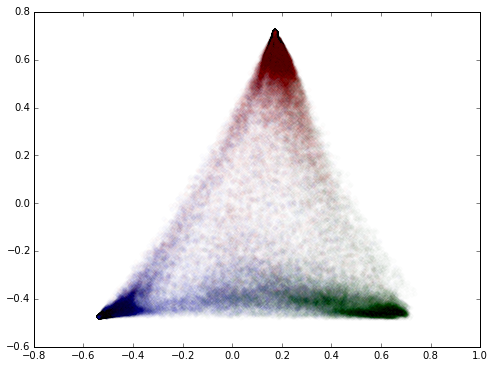

In [226]:
alpha = -(63) * numpy.pi / 180.
new_x = new_probs[:, 0] * cos(alpha) + new_probs[:, 1] * sin(alpha)
new_y = -1. * new_probs[:, 0] * sin(alpha) + new_probs[:, 1] * cos(alpha)
plt.scatter(new_x[labels==0], new_y[labels==0], c='b', alpha=0.01)
plt.scatter(new_x[labels==1], new_y[labels==1], c='g', alpha=0.01)
plt.scatter(new_x[labels==2], new_y[labels==2], c='r', alpha=0.01)
plt.show()

In [229]:
reg_labels = full_data.label.values
reg_values = new_x
regression_result = generate_result(roc_auc_score(reg_labels > 0, reg_values, sample_weight=(reg_labels != 2)*1),
                                    roc_auc_score(reg_labels > 0, reg_values, sample_weight=(reg_labels != 1)*1),
                                    roc_auc_score(reg_labels > 1, reg_values, sample_weight=(reg_labels != 0)*1), 
                                    label='regression')

In [230]:
result = pandas.concat([pandas.DataFrame(baseline_result), pandas.DataFrame(multiclass_result),
                       regression_result])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
baseline,0.941541,0.975252,0.950493
multiclass,0.940683,0.978422,0.962802
regression,0.938621,0.884126,0.177469


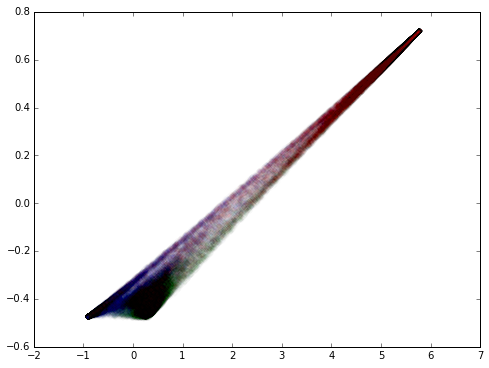

In [215]:
# thr = 0
# new_new_x = (new_x - 2.) * (new_y < thr) - (new_x - 2.) * (new_y >= thr)
new_new_x = (new_x + 2.) + 5.*new_y
plt.scatter(new_new_x[labels==0], new_y[labels==0], c='b', alpha=0.01)
plt.scatter(new_new_x[labels==1], new_y[labels==1], c='g', alpha=0.01)
plt.scatter(new_new_x[labels==2], new_y[labels==2], c='r', alpha=0.01)
plt.show()

In [216]:
reg_labels = full_data.label.values
reg_values = new_new_x
regression_result = generate_result(roc_auc_score(reg_labels > 0, reg_values, sample_weight=(reg_labels != 2)*1),
                                    roc_auc_score(reg_labels > 0, reg_values, sample_weight=(reg_labels != 1)*1),
                                    roc_auc_score(reg_labels > 1, reg_values, sample_weight=(reg_labels != 0)*1), 
                                    label='regression')

In [217]:
result = pandas.concat([pandas.DataFrame(baseline_result), pandas.DataFrame(multiclass_result),
                       regression_result])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
baseline,0.941541,0.975252,0.950493
multiclass,0.940683,0.978422,0.962802
regression,0.839091,0.977240,0.946321


### BDTs planes

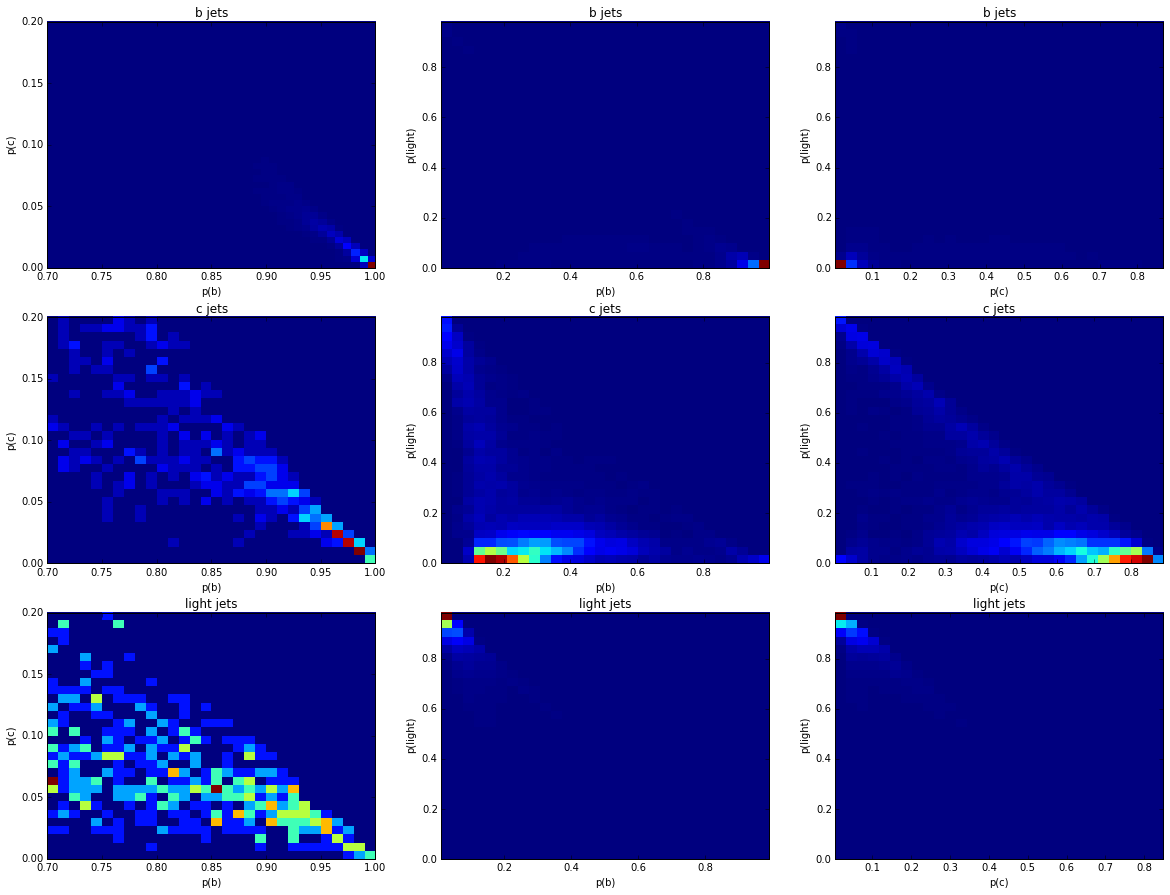

In [44]:
plt.figure(figsize=[20, 15])

plt.subplot(3,3,1)
hist2d(multi_probs_b[:, 0], multi_probs_b[:, 1], bins=40, range=[[0.7, 1], [0, 0.2]]), xlabel('p(b)'), ylabel('p(c)'), title('b jets')

plt.subplot(3,3,2)
hist2d(multi_probs_b[:, 0], multi_probs_b[:, 2], bins=30), xlabel('p(b)'), ylabel('p(light)'), title('b jets')

plt.subplot(3,3,3)
hist2d(multi_probs_b[:, 1], multi_probs_b[:, 2], bins=30), xlabel('p(c)'), ylabel('p(light)'), title('b jets')

plt.subplot(3,3,4)
hist2d(multi_probs_c[:, 0], multi_probs_c[:, 1], bins=30, range=[[0.7, 1], [0, 0.2]]), xlabel('p(b)'), ylabel('p(c)'), title('c jets')

plt.subplot(3,3,5)
hist2d(multi_probs_c[:, 0], multi_probs_c[:, 2], bins=30), xlabel('p(b)'), ylabel('p(light)'), title('c jets')

plt.subplot(3,3,6)
hist2d(multi_probs_c[:, 1], multi_probs_c[:, 2], bins=30), xlabel('p(c)'), ylabel('p(light)'), title('c jets')

plt.subplot(3,3,7)
hist2d(multi_probs_light[:, 0], multi_probs_light[:, 1], bins=30, range=[[0.7, 1], [0, 0.2]]), xlabel('p(b)'), ylabel('p(c)'), title('light jets')

plt.subplot(3,3,8)
hist2d(multi_probs_light[:, 0], multi_probs_light[:, 2], bins=30), xlabel('p(b)'), ylabel('p(light)'), title('light jets')

plt.subplot(3,3,9)
hist2d(multi_probs_light[:, 1], multi_probs_light[:, 2], bins=30), xlabel('p(c)'), ylabel('p(light)'), title('light jets')
pass

# Hierarchical multiclassification

In [53]:
full_data['fake_request'] = 1
multi_p_features = ['p_b', 'p_c', 'p_light']
for i, f in enumerate(multi_p_features):
    full_data[f] = multi_probs[:, i]

In [54]:
full_data['fake_request'] = 1
multi_relation_p_features = ['p_b_c', 'p_b_light', 'p_c_light']
indices = [(0, 1), (0, 2), (1, 2)]
for i, (f, ind) in enumerate(zip(multi_relation_p_features, indices)):
    full_data[f] = multi_probs[:, ind[0]] / multi_probs[:, ind[1]]

### Decision Train regression

In [56]:
tt_base = RandomForestRegressor(n_estimators=50, max_depth=6, 
                                 max_features=0.7)
tt_folding_regression = FoldingRegressor(tt_base, n_folds=2, random_state=11,
                                         parallel_profile='threads-2', 
                                         features=sv_features + multi_p_features + multi_relation_p_features + ['bdt1', 'bdt2'])
%time tt_folding_regression.fit_lds(data_multi_lds)
pass

CPU times: user 32.9 s, sys: 120 ms, total: 33 s
Wall time: 16.7 s


In [57]:
report = tt_folding_regression.test_on_lds(data_multi_lds)

KFold prediction using folds column


In [58]:
from sklearn.metrics import mean_squared_error
lc = report.learning_curve(mean_squared_error, steps=1)

KFold prediction using folds column
Estimator clf doesn't support stage predictions


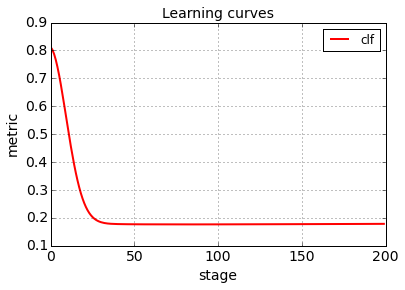

In [51]:
lc.plot()
# ylim(550, 540)

In [52]:
# tt_folding_regression.estimators[1].estimators = tt_folding_regression.estimators[1].estimators[:125*50]

In [59]:
reg_values = tt_folding_regression.predict(full_data)

KFold prediction using folds column


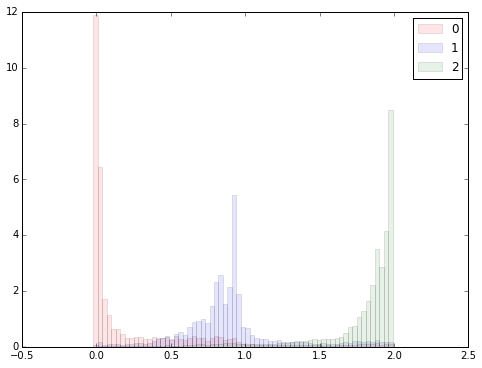

In [60]:
figsize(8, 6)
for label in numpy.unique(full_data.label.values):
    hist(reg_values[full_data.label.values == label], 
         bins=100, alpha=0.1, normed=True, range=(-0.5, 2.5), label=str(label))
xlim(-0.5, 2.5)
# ylim(0, 0.05)
legend()

In [61]:
reg_labels = full_data.label.values
regression_result = generate_result(roc_auc_score(reg_labels > 0, reg_values, sample_weight=(reg_labels != 2)*1),
                                    roc_auc_score(reg_labels > 0, reg_values, sample_weight=(reg_labels != 1)*1),
                                    roc_auc_score(reg_labels > 1, reg_values, sample_weight=(reg_labels != 0)*1), 
                                    label='regression')

In [62]:
result = pandas.concat([pandas.DataFrame(baseline_result), pandas.DataFrame(multiclass_result),
                       regression_result])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
baseline,0.941541,0.975252,0.950493
multiclass,0.940683,0.978422,0.962802
regression,0.886915,0.977685,0.930735


### Ranker

In [61]:
from hep_ml.gradientboosting import UGradientBoostingRegressor
from hep_ml.losses import RankBoostLossFunction
from rep.estimators import SklearnClassifier

### decision train ranker

In [66]:
tt_base = GradientBoostingRegressor(learning_rate=0.02, n_estimators=100, max_depth=6, 
                                 max_features=6)
tt_folding_ranking = FoldingRegressor(SklearnClassifier(tt_base), n_folds=2, random_state=11,
                                      parallel_profile='threads-2', 
                                     features=sv_features + multi_relation_p_features + ['bdt1', 'bdt2'])
%time tt_folding_ranking.fit_lds(data_multi_lds)
pass

CPU times: user 30.1 s, sys: 154 ms, total: 30.3 s
Wall time: 15.6 s


In [67]:
sv_features + multi_p_features + ['bdt1', 'bdt2']

['SVM',
 'SVMC',
 'SVR',
 'SVPT',
 'SVDR',
 'SVN',
 'SVQ',
 'SVFDChi2',
 'SVSumIPChi2',
 'log_SVFDChi2',
 'log_SVSumIPChi2',
 'p_b',
 'p_c',
 'p_light',
 'bdt1',
 'bdt2']

In [68]:
tt_folding_ranking.estimators[0].feature_importances_

array([ 0.0078063 ,  0.01431876,  0.0038102 ,  0.00378639,  0.00419443,
        0.00199474,  0.00069288,  0.02586434,  0.04083343,  0.04896123,
        0.02372659,  0.08047497,  0.36046889,  0.14166704,  0.04255182,
        0.19884799])

### ugb ranker

In [72]:
ranker_base = UGradientBoostingRegressor(loss=RankBoostLossFunction(request_column='fake_request'), subsample=0.6, 
                                         n_estimators=400, max_depth=6, 
                                         train_features=sv_features + ['bdt1', 'bdt2'])
ranker = FoldingRegressor(ranker_base, n_folds=2, random_state=11,
                          parallel_profile='threads-2')
%time ranker.fit_lds(data_multi_lds)
pass

Problem while training on the node, report:
 (0, 5576, '77.88.19.57-red.dhcp.yndx.net', TypeError('range() integer end argument expected, got NoneType.',))
Problem while training on the node, report:
 (1, 5576, '77.88.19.57-red.dhcp.yndx.net', TypeError('range() integer end argument expected, got NoneType.',))
CPU times: user 292 ms, sys: 30.1 ms, total: 323 ms
Wall time: 320 ms


In [70]:
ranker.estimators[0].feature_importances_

ZeroDivisionError: division by zero

In [56]:
ranks = ranker.predict(full_data)
tt_ranks = tt_folding_ranking.predict(full_data)

KFold prediction using folds column
KFold prediction using folds column


### pdfs form for dt ranker

In [73]:
for label in numpy.unique(full_data.label.values):
    hist(tt_ranks[full_data.label.values == label], bins=100, alpha=0.1, 
         normed=True, range=(-20, 10), label=str(label))
legend()

NameError: name 'tt_ranks' is not defined

### pdfs from for ugb ranker

In [74]:
for label in numpy.unique(full_data.label.values):
    hist(ranks[full_data.label.values == label], bins=100, alpha=0.1, normed=True, range=(-20, 10), label=str(label))
legend()

NameError: name 'ranks' is not defined

In [75]:
labels = full_data.label.values
ranker_result = generate_result(roc_auc_score(labels[labels != 2] > 0, ranks[labels != 2]),
                                roc_auc_score(labels[labels != 1] > 0, ranks[labels != 1]),
                                roc_auc_score(labels[labels != 0] > 1, ranks[labels != 0]), 
                                label='ranker')

NameError: name 'ranks' is not defined

In [76]:
tt_ranker_result = generate_result(roc_auc_score(labels[labels != 2] > 0, tt_ranks[labels != 2]),
                                   roc_auc_score(labels[labels != 1] > 0, tt_ranks[labels != 1]),
                                   roc_auc_score(labels[labels != 0] > 1, tt_ranks[labels != 0]), 
                                   label='dt ranker')

NameError: name 'tt_ranks' is not defined

# Results

In [77]:
result = pandas.concat([baseline_result, multiclass_result,
                       regression_result, ranker_result, tt_ranker_result])
result.index = result['name']
result = result.drop('name', axis=1)
result

NameError: name 'ranker_result' is not defined